## In this notebook, I will replicate vision transformer and use it to classify food images.

The paper for the vision transformer is as follows:
<a>https://arxiv.org/abs/2010.11929</a>

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import matplotlib.pyplot as plt




In [2]:
# Get helper functions for plotting
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

# Import accuracy metric
from helper_functions import accuracy_fn, download_data  # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classe

helper_functions.py already exists, skipping download


### 1. Setup Data

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [4]:
train_dir = image_path/ 'train'
test_dir = image_path/ 'test'

##### 1.1 Load the data into train and test sets

In [5]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])

In [6]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=manual_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=manual_transform)

In [7]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=1)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True, num_workers=1)

In [8]:
class_names = train_dataset.classes
class_names_indexes = train_dataset.class_to_idx

class_names

['pizza', 'steak', 'sushi']

##### 1.2 visualise a single image

In [9]:
# visualising image from dataset
image, label = train_dataset[0]

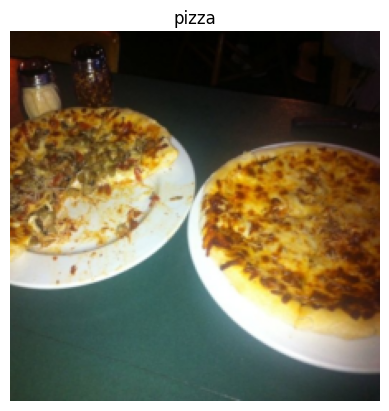

In [10]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

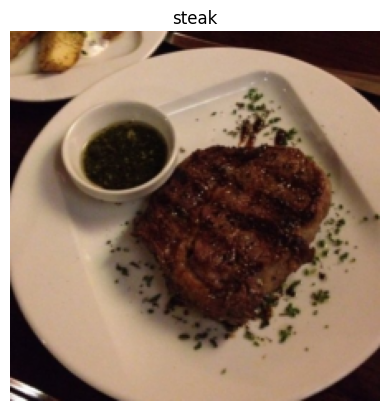

In [11]:
# visualise image from dataloader
image_batch, label_batch = next(iter(train_dataloader))

image_dataloader, label_dataloader = image_batch[0], label_batch[0]

plt.imshow(image_dataloader.permute(1,2,0))
plt.title(class_names[label_dataloader])
plt.axis(False);


**Looks like the data is loading perfectly!**

#### Steps to Build Vision Transformer

The equations that form the base of Vit architecture are as follows:
<img src="/Users/Akhil/VSCode/Pytorch-Vision-Transformer/Vit Architecture equations.png" alt="Alt Text">

In all equations "z" is the raw output of a particular layer.
1. z0 is the output of the initial patch embedding layer
2. zl' is output of an intermediate layer
3. zl is the ouput of a particular layer 

To further understand each equation:
1. <u>**In equations1:**</u> Make the image into patchs and them convert these into position embedding.<br/>
In vector form, the embedding might look something like:
<ul>
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
Where each of the elements in the vector is learnable (their requires_grad=True).
</ul>

2. <u>**In equation 2:**</u> There is a multi head self attention layer wrapping a layer norm . <br/>
There is a skil connection in the end which means additng the inout of some layers to the output of layers. This allows the model to remember both global and local information. Also helps in mitigation the vanishing gradient problem
<ul>x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input </ul>
<ul>Imagine there is a picture, and we want to understand what's happening in different parts of that picture. To do that, we divide the picture into smaller pieces called patches. Each patch is like a mini-picture that the model will analyze.

Equation 2 tells us how to calculate the value of each patch. It says that the value of a patch is determined by a combination of the values of all the patches in the image. This means that each patch looks at the values of all the other patches to figure out its own value.

To do this, the model uses something called "self-attention." Self-attention is like having a conversation between patches. Each patch listens to what the other patches have to say and decides how much it should pay attention to each one. It does this by giving each patch a score, which represents how important that patch is for understanding the current patch.

Once each patch has a score for all the other patches, it multiplies each score by the value of the corresponding patch. Then it adds up all these multiplied values to get the final value of the patch.

So, Equation 2 is like a recipe that tells the model how to calculate the value of each patch by having them talk to each other and combining their information. This helps the model understand different parts of the image and make sense of what it sees.</ul>

3. <u>**In equation 3:**</u> This says that for every layer from through to (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).
<ul>
The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like:

x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
Notice the skip connection on the end (adding the input of the layers to the output of the layers).</ul>
<ul>Equation 3 is all about updating the values of the patches based on the calculated scores from Equation 2. It tells us how each patch should adjust its value to incorporate information from other patches.</ul>

4. <u>**In equation 4:**</u> This is the last layer and a layer norm is wrapper around the output.
<ul> y = Linear_layer(LN_layer(x_output_MLP_block[0]))</ul>
<ul>the updated patch values are transformed to produce the output of the model. This equation allows the model to make predictions or decisions based on the processed information.

Once each patch has been updated using Equation 3, the model needs to combine all the patch values into a single representation that captures the overall understanding of the image.

Equation 4 tells us how to transform the updated patch values. It involves multiplying the patch values by a set of learnable parameters called weights and adding a bias term. This process is similar to multiplying and adding numbers together to get a result.

The weights and bias terms are learned during the training of the model. They are adjusted to find the best combination that helps the model make accurate predictions based on the processed patch values.

To summarize, Equation 4 takes the updated values of the patches, applies learnable weights and a bias term, and combines them to generate the output of the vision transformer. It transforms the patch values into a compact representation that captures the essential information for decision-making.

</ul>

# 2. Equation 1: split data into patches and add position embeddings

In this i'll start with patch embedding which means the entire image will be broken down into smaller batches and then the idea is to create an embedding (learnable representation of some form or vector) for all the patches. All the embeddings are in numeric form so that they are learnable.
<img src="/Users/Akhil/VSCode/Pytorch-Vision-Transformer/Vit Intro.png" alt="Alt Text">
<li>  D is the size of the patch embeddings, different values for various sized ViT models can be found in Table 1</li>
<li>The image start as 2D with size H X W XC</li>
    <ul><li> (H,W) is the resolution of the image</li></ul>
    <ul><li> C is the number of channels</li></ul>
<li> The image gets converted to a sequence of flattened 2D patches with size N X (P.P.C)</li>
    <ul><li> (P,P) is the resolution of each path</li></ul>
    <ul><li> N = HW/P.P is the resulting number of patches, which is the input sequence length for the transformer</li></ul>

##### 2.1 Calculate path embedding by hand as an example

In [21]:
height = 224
width = 224
color_channels = 3
patches = 16

number_of_patches = int((height*width) / (patches*patches))

print("The number of patches are ",number_of_patches)

The number of patches are  196


In [23]:
# let me convert by hand and see input and output shapes.
embedding_input_shape = (height, width, color_channels)

embedding_output_shape = (number_of_patches, (patches**2)*color_channels)

print(f"Input shape (single 2D image): {embedding_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)
